Dog data
https://data.mendeley.com/datasets/ktx4cj55pn/1
https://www.imaios.com/en/vet-anatomy/dog/dog-osteology

Chest data
https://www.kaggle.com/datasets/nih-chest-xrays/data?select=Data_Entry_2017.csv

Random chest data
https://www.kaggle.com/datasets/nih-chest-xrays/sample?resource=download

###### Importing Libraries

###### Import Libraries: Import the necessary libraries for data handling and visualization.

In [1]:
import pandas as pd
import os

###### Define Paths: Define the paths to your CSV and image folder.

In [2]:
# IMPORTANT: Use the correct file name here
csv_path = '../data/sample_labels.csv'
images_dir = '../data/images' # Assuming images are directly in the data folder. Adjust if they are in a subfolder.

###### Load CSV: Load the sample_labels.csv file into a Pandas DataFrame.

In [4]:
df = pd.read_csv(csv_path)
print(df.head())

        Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   
3  00000030_001.png                                        Atelectasis   
4  00000032_001.png                        Cardiomegaly|Edema|Effusion   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   
3            1          30        079Y              M            PA   
4            1          32        055Y              F            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  \
0                3056                 2544           

###### Data Cleaning & Binary Labeling:
- Create a new is_abnormal column.
- Use .loc to set the value to 0 for rows where Finding Labels is 'No Finding'.
- Set all other rows to 1.

In [5]:
df['is_abnormal'] = 1
df.loc[df['Finding Labels'] == 'No Finding', 'is_abnormal'] = 0
print(df['is_abnormal'].value_counts())

is_abnormal
0    3044
1    2562
Name: count, dtype: int64


###### Create Two Datasets:
- Images Dataset: Create a DataFrame that links the image filenames to the new is_abnormal label.

In [6]:
image_data = df[['Image Index', 'is_abnormal']].copy()
image_data['Image Index'] = image_data['Image Index'].apply(lambda x: os.path.join(images_dir, x))
print(image_data.head())

                       Image Index  is_abnormal
0  ../data/images/00000013_005.png            1
1  ../data/images/00000013_026.png            1
2  ../data/images/00000017_001.png            0
3  ../data/images/00000030_001.png            1
4  ../data/images/00000032_001.png            1


- Structured Data: Create a separate DataFrame for the structured features.

In [7]:
structured_data = df[['Patient Age', 'Patient Gender', 'is_abnormal']].copy()
print(structured_data.head())

  Patient Age Patient Gender  is_abnormal
0        060Y              M            1
1        057Y              M            1
2        077Y              M            0
3        079Y              M            1
4        055Y              F            1


Vision Model Training (PyTorch)
1. Import Libraries: Add PyTorch and torchvision imports.

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

2. Create a Custom Dataset Class: This is a crucial step for handling your custom data.

In [9]:
class XrayDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name).convert('RGB')
        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

3. Define Transforms: Define the transformations for your images.

In [10]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

4. Instantiate Dataset and DataLoader:

In [11]:
dataset = XrayDataset(dataframe=image_data, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

5. Load Pre-trained Model: Load MobileNetV2 and modify the final layer for binary classification.
   
   MobileNetV2 provides a very efficient mobile-oriented model that can be used as a base for many visual recognition tasks
   
   Source: https://research.google/blog/mobilenetv2-the-next-generation-of-on-device-computer-vision-networks/

In [12]:
# --- Model Architecture Selection ---
# We use MobileNetV2, a lightweight and efficient CNN, as our backbone model.
# This choice is strategic for several reasons:
#
# 1. Efficiency: Its small size and low computational cost make it ideal for
#    deployment on resource-constrained devices, which is common in real-world
#    clinical settings.
# 2. Transfer Learning: MobileNetV2 is pre-trained on the massive ImageNet
#    dataset. By leveraging this knowledge, we can achieve high performance
#    with a smaller, task-specific dataset, addressing the challenge of data
#    scarcity in veterinary medicine.
# 3. Proven Performance: Numerous academic studies have validated MobileNetV2's
#    effectiveness for medical image analysis, including chest X-ray classification.
#
# --- Citations ---
# - "MobileNetV2: A highly efficient convolutional neural network architecture for mobile and embedded vision applications."
#   https://www.geeksforgeeks.org/computer-vision/what-is-mobilenet-v2/
# - "Application of MobileNet Convolutional Neural Network for Classification of Pediatric Images of Chest X-rays"
#   https://aprepro.org.br/conbrepro/2020/anais/arquivos/09262020_180940_5f6fb12091cdd.pdf
# - "An efficient, lightweight MobileNetV2-based fine-tuned model for COVID-19 detection using chest X-ray images"
#   https://www.aimspress.com/article/doi/10.3934/mbe.2023368?viewType=HTML
# - "High-precision multiclass classification of lung disease through customized MobileNetV2 from chest X-ray images"
#   https://researchers.cdu.edu.au/files/72291156/1_s2.0_S0010482523001117_main.pdf
model = models.mobilenet_v2(weights='DEFAULT')
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

# Check for MPS (M1 GPU) and move the model to it
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

Using device: mps


Train the Model (Simplified): This is a simplified training loop for a proof-of-concept.

Starting training...
Epoch 1, Loss: 0.5553, Duration: 191.42 seconds, LR: 0.001
Epoch 2, Loss: 0.5149, Duration: 744.46 seconds, LR: 0.001
Epoch 3, Loss: 0.4868, Duration: 196.43 seconds, LR: 0.0001
Epoch 4, Loss: 0.2914, Duration: 190.56 seconds, LR: 0.0001
Epoch 5, Loss: 0.1618, Duration: 191.23 seconds, LR: 0.0001
Epoch 6, Loss: 0.0812, Duration: 337.46 seconds, LR: 1e-05
Epoch 7, Loss: 0.0368, Duration: 189.79 seconds, LR: 1e-05
Epoch 8, Loss: 0.0350, Duration: 191.85 seconds, LR: 1e-05
Epoch 9, Loss: 0.0302, Duration: 194.02 seconds, LR: 1.0000000000000002e-06
Epoch 10, Loss: 0.0268, Duration: 198.91 seconds, LR: 1.0000000000000002e-06
Epoch 11, Loss: 0.0253, Duration: 202.98 seconds, LR: 1.0000000000000002e-06
Epoch 12, Loss: 0.0273, Duration: 208.65 seconds, LR: 1.0000000000000002e-07
Epoch 13, Loss: 0.0315, Duration: 198.38 seconds, LR: 1.0000000000000002e-07
Epoch 14, Loss: 0.0282, Duration: 197.29 seconds, LR: 1.0000000000000002e-07
Epoch 15, Loss: 0.0296, Duration: 199.20 se

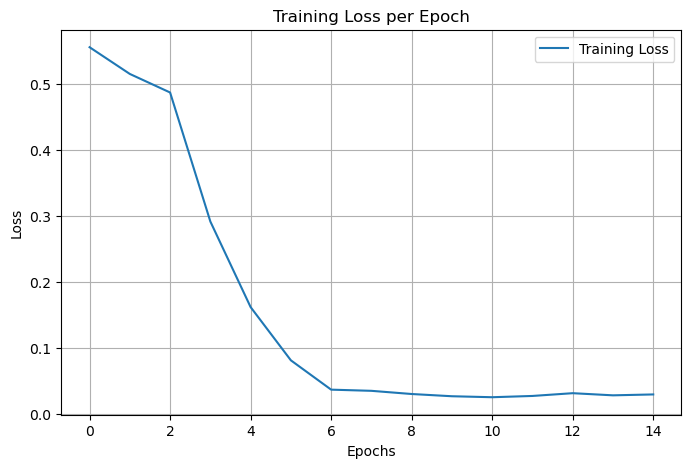

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time # We'll need this to track time

# Define the optimizer and criterion as before
"""
nn.BCEWithLogitsLoss() is used for binary classification tasks. 
It is a more numerically stable version of nn.BCELoss() because 
it combines the Sigmoid activation and the Binary Cross Entropy 
loss into a single function. This prevents potential issues like 
floating-point overflow and underflow that can occur when 
calculating the logarithm of a very small number 
(which happens with a separate Sigmoid followed by BCELoss).
Source: https://docs.pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
"""
criterion = nn.BCEWithLogitsLoss()
"""
optimizer = optim.Adam(model.parameters(), lr=0.001)
The Adam (Adaptive Moment Estimation) optimizer is chosen because 
it is a highly effective and widely used algorithm for training 
deep neural networks. It combines the benefits of two other popular 
optimizers, RMSProp and Momentum, by calculating adaptive learning 
rates for each parameter. This makes it well-suited for problems 
with large datasets, noisy or sparse gradients, and a wide range of model architectures.
Source: https://arxiv.org/pdf/1412.6980 (Kingma, D. P., & Ba, J. (2014). Adam: A Method for Stochastic Optimization. arXiv preprint arXiv:1412.6980.)
"""
optimizer = optim.Adam(model.parameters(), lr=0.001)
"""
A learning rate scheduler is a strategy to adjust the 
learning rate during training. StepLR is a simple yet 
effective scheduler that decreases the learning rate 
by a multiplicative factor (gamma) at a fixed interval 
of epochs (step_size). This is beneficial because a higher 
learning rate early in training can lead to faster convergence, 
while a lower learning rate later on allows for more fine-grained 
adjustments, preventing the model from overshooting the optimal solution.
Source: https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html
"""
# NEW: Add a learning rate scheduler
# This will reduce the learning rate by a factor of 0.1 every 5 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Lists to track loss and time for plotting and printing
epoch_losses = []
epoch_times = []

print("Starting training...")
start_total_time = time.time()

# We'll train for 15 epochs to better see the effect of the scheduler
for epoch in range(15): 
    start_epoch_time = time.time()
    running_loss = 0.0
    
    # We will use the DataLoader from the previous steps
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)

    # Apply the learning rate scheduler after each epoch
    scheduler.step()

    # Calculate and store the average loss and time for the epoch
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_losses.append(epoch_loss)
    
    end_epoch_time = time.time()
    epoch_duration = end_epoch_time - start_epoch_time
    epoch_times.append(epoch_duration)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Duration: {epoch_duration:.2f} seconds, LR: {optimizer.param_groups[0]['lr']}")

end_total_time = time.time()
total_duration = end_total_time - start_total_time
print(f"\nTraining complete in {total_duration:.2f} seconds.")

# --- Save the model after the loop ---
torch.save(model.state_dict(), '../models/cnn_model.pth')

# --- Plot the training loss ---
plt.figure(figsize=(8, 5))
plt.plot(epoch_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

Structured Model Training (XGBoost)

Import Libraries:

In [15]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


Prepare Structured Data:
- Use LabelEncoder to convert the Patient Gender column into numerical values (e.g., Male=1, Female=0).

In [16]:
# Create a separate DataFrame for the structured features.
structured_data = df[['Patient Age', 'Patient Gender', 'is_abnormal']].copy()

In [17]:
# Correcting the Patient Age column
# 1. Remove the 'Y' from the age string
# 2. Convert the cleaned string to a numeric type (e.g., integer)
# This is crucial for the XGBoost model to work correctly
structured_data['Patient Age'] = structured_data['Patient Age'].str.replace('Y', '', regex=False).astype(int)

In [18]:
# Use LabelEncoder to convert the 'Patient Gender' column to numerical values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
structured_data['Patient Gender'] = le.fit_transform(structured_data['Patient Gender'])

print("Data types after cleaning:")
print(structured_data.dtypes)
print("\nFirst 5 rows of prepared structured data:")
print(structured_data.head())

# Define Features and Target
X_structured = structured_data[['Patient Age', 'Patient Gender']]
y_structured = structured_data['is_abnormal']

Data types after cleaning:
Patient Age       int64
Patient Gender    int64
is_abnormal       int64
dtype: object

First 5 rows of prepared structured data:
   Patient Age  Patient Gender  is_abnormal
0           60               1            1
1           57               1            1
2           77               1            0
3           79               1            1
4           55               0            1


In [19]:
# Use LabelEncoder to convert the 'Patient Gender' column to numerical values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
structured_data['Patient Gender'] = le.fit_transform(structured_data['Patient Gender'])

Structured Model Training (XGBoost)

Import Libraries:

In [20]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Prepare Structured Data:

- Use LabelEncoder to convert the Patient Gender column into numerical values (e.g., Male=1, Female=0).

In [21]:
le = LabelEncoder()
structured_data['Patient Gender'] = le.fit_transform(structured_data['Patient Gender'])

Define Features and Target:

In [22]:
X_structured = structured_data[['Patient Age', 'Patient Gender']]
y_structured = structured_data['is_abnormal']

Train-Test Split (Optional but good practice):

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_structured, y_structured, test_size=0.2, random_state=42)

Train XGBoost Classifier:

In [24]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
xgb_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


Save the Model: Save the trained XGBoost model.

In [25]:
xgb_model.save_model('../models/structured_model.json')